# Tweets sentiment

In [52]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
import pickle
from wordcloud import WordCloud
import os
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm_notebook as tqdm
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.style.use('seaborn-deep')

from typing import List

data_path = 'data'

Retreive the airport data from https://openflights.org/data.html.

In [2]:
airports_filename = 'airports.csv'
routes_filename = 'routes.csv'

In [3]:
airports = pd.read_csv(os.path.join(data_path, 'airports.csv'))
airports.set_index('Airport Id', inplace=True)

In [4]:
airports

,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database timezone,Type,Source
Airport Id,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby,airport,OurAirports
7,Narsarsuaq Airport,Narssarssuaq,Greenland,UAK,BGBW,61.160500,-45.425999,112,-3,E,America/Godthab,airport,OurAirports
8,Godthaab / Nuuk Airport,Godthaab,Greenland,GOH,BGGH,64.190903,-51.678101,283,-3,E,America/Godthab,airport,OurAirports
9,Kangerlussuaq Airport,Sondrestrom,Greenland,SFJ,BGSF,67.012222,-50.711603,165,-3,E,America/Godthab,airport,OurAirports


## TF-IDF analysis of Twitter

The tweets have been retreived from twitter's API. The data we have collected can be found [here](https://1drv.ms/u/s!AoyV20xD2_Tx0vIuF0HGgFg-5CyaIw).
Every file coresponds to the id of an airport, and contain up to 100 of the latest tweets from the given airport (the dataset was generated on 2018-11-08).
As tweets can be multiline, each tweet is seperated by ';;;' in the files.

In [5]:
tweets = {
    row['Name']: ''.join(open(
        os.path.join(data_path, 'tweets', str(index)), 'r', encoding='utf-8'
    ).readlines())
    for index, row in airports.iterrows()
}

Each tweet is tokenized and cleaned to remove stopworld, punctuation, and blacklisted words, such as keywords used by twitter.

In [6]:
blacklisted_tokens = [
    'rt',
    'amp'
]
def tokenize(text: str, names: set = []) -> List[str]:
    sw = stopwords.words('english')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens
                  if token not in names
                  and token not in sw
                  and not token.isdigit()
                  and token not in blacklisted_tokens
         ]
    return tokens

In [7]:
%%capture cap --no-stderr
tokens = { airport: tokenize(document) for airport, document in tqdm(tweets.items()) }

In [8]:
def calculate_n_ts(tokens: list, documents: list) -> set:
    ''' Calculate the n_ts for a list of tokens given a list of documents
    '''
    return {
        word: sum(1 for document in documents if word in document)
           for word in set(tokens)
    }

As calculating how many documents each of the words occure in takes some time, we have cheated a little and saved the result. To optimize the calculations, we have transformed each of the documents into sets.

In [ ]:
# tokens_set = { airport: set(document) for airport, document in tokens.items() }
# n_ts = { 
#     airport: calculate_n_ts(ts, tokens_set.values()) 
#     for airport, ts in tqdm(tokens.items())
# }
# with open(os.path.join(data_path, 'n_ts.data'), 'wb') as f:
#     pickle.dumb(f)

In [9]:
with open(os.path.join(data_path, 'n_ts.data'), 'rb') as f:
    n_ts = pickle.load(f)

Calculating the IDF can now be done using the following function.

In [10]:
def calculateIDF(nts: set, N: int, base=2) -> set:
    return { word: math.log(N / n_t, base)
        for word, n_t in nts.items()
    }

In [11]:
N = len(list(airports['Name']))
IDF = {
    airport: calculateIDF(n_ts[airport], N)
    for airport in tqdm(list(airports['Name']))
}

Calculate the TF_IDF

In [12]:
def calculateTF_IDF(tfs: set, IDFs: set) -> set:
    return {
        word: tf * IDFs[word]
        for word, tf in tfs.items()
    }

In [14]:
freq = { airport: FreqDist(ts) for airport, ts in tokens.items() }

In [15]:
TF_IDF = {
    airport: calculateTF_IDF(freq[airport], IDF[airport])
    for airport in tokens.keys()
}

The most used words in all of the documents:

In [17]:
all_tokens = [t for ts in tokens.values() for t in ts]

In [18]:
freqency_total = FreqDist(all_tokens)

## Word clouds

In [21]:
def drawWordCloud(text: str, title: str):
    wordcloud = WordCloud().generate(text)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title(title)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.show()

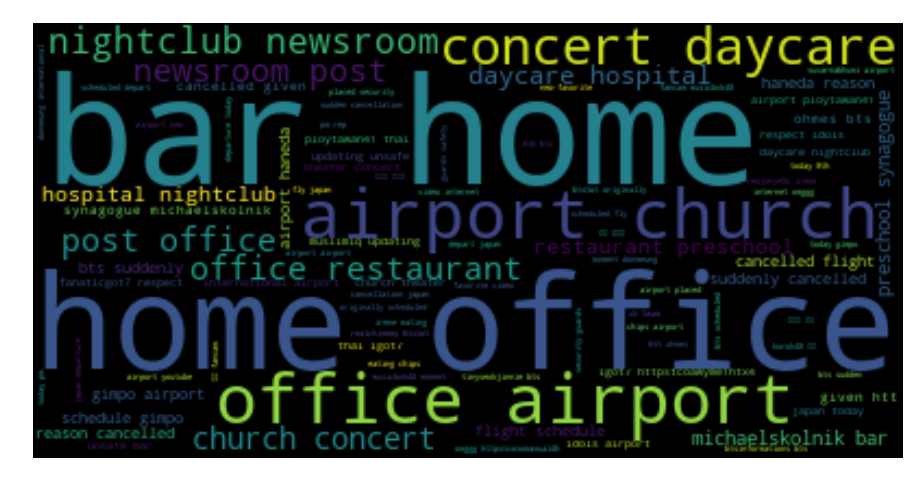

In [22]:
drawWordCloud(' '.join(all_tokens), 'All tokens')

## Sentiment

To calculate the sentiment of each of the airports, we are using the data set created in [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).
This data set contains over 10,000 individual words and their happiness score, which is generated by having many unique people rate each of the words and calculating a aggregated score based on this.

In [30]:
happiness = pd.read_csv(os.path.join(data_path, 'sentiment.csv'), delimiter='\t')
happiness

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332
5,laugh,6,8.22,1.3746,1002,3998,4488,647
6,laughing,7,8.20,1.1066,1579,--,--,1122
7,excellent,8,8.18,1.1008,1496,1756,3155,--
8,laughs,9,8.18,1.1551,3554,--,--,2856
9,joy,10,8.16,1.0568,988,2336,2723,809


We will be using the average happiness score for each of the words to calculate the sentiment for each of the airports.

In [32]:
h_avg = { happiness['word'].iloc[i]: happiness['happiness_average'].iloc[i] 
         for i in range(len(happiness.word)) 
    }

In [47]:
def calculate_sentiment(tokens: list, h_avg: dict) -> int:
    tokens = [word for word in tokens if word in h_avg]
    if len(tokens) == 0: 
        return 0
    frequency = FreqDist(tokens)
    return sum(h_avg[word] * frequency[word] for word in tokens) / len(tokens)

In [33]:
tweets = { airport: tws.split(';;;')
          for airport, tws in tweets.items()
     }

In [34]:
sentiment = {
    airport: [calculate_sentiment(tokenize(tweet), h_avg) for tweet in ts]
    for airport, ts in tweets.items()
}

In [43]:
tweets_all = [tweet for ts in tweets.values() for tweet in ts]

In [48]:
sentiment_all = [score for ss in sentiment.values() for score in ss]

In [41]:
def plotDistribution(data: list, title: str):
    sorted_data = [x for x in sorted(data) if x < 10 and x != 0]
    fig, ax = plt.subplots(1, figsize=(16,8))
    ax.hist(sorted_data, bins=30)
    ax.set_title(title)
    ax.set_xlabel('Happiness score')
    ax.set_ylabel('Frequency')
    fig.show()

c:\python37\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


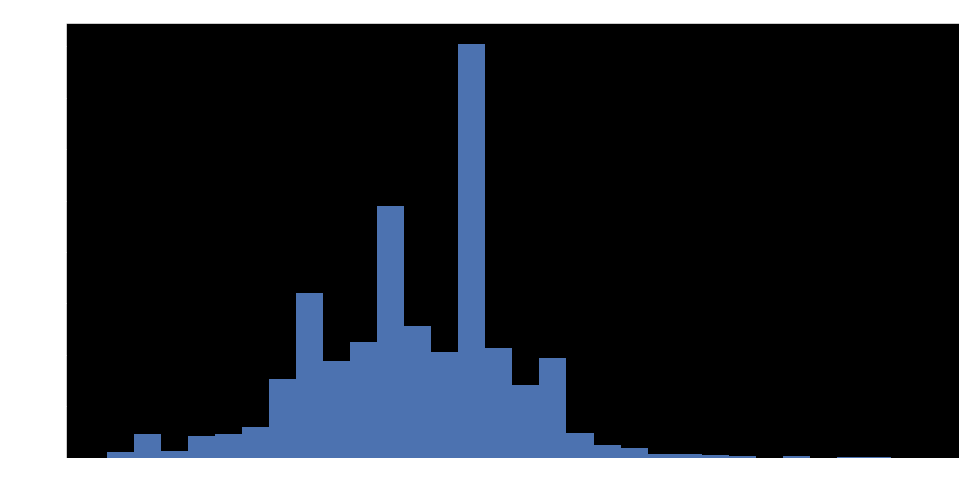

In [50]:
plotDistribution(sentiment_all, 'Overall sentiment of tweets')

In [57]:
mean = np.mean(sentiment_all)
std = np.std(sentiment_all)
print('Sentiment Mean and standard deviation of all the tweets {0:f}'.format(mean))

Mean sentiment of all the tweets 3.689032


In [ ]:
tokens_all = [token for ts in tokens.values() for token in ts]